In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import sys, os
sys.path.append('./src/')
import toolbox
from toolbox import *

result_names = ['BBT_Tiingo',                #0
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',     #2
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',     #4
                'BBT_future_BITX',
                'BBT_future_BITW20',         #6
                'BBT_future_BITW70', 
                'BBT_future_BITW100',        #8
                'BBT_future_CRIX']

risk_measures = ['Variance',
                 'ES q=0.05', 'ES q=0.01',
                 'VaR q=0.05', 'VaR q=0.01', 
                 'ERM k=10', 'CH']

order = ['BBT_Tiingo',    
         'BBT_future_CRIX',  'BBT_future_BITX', 'BBT_future_BITW100', 
         'BBT_future_BITW20',  'BBT_future_BITW70',
         'BBT_future_Tiingo_ada', 'BBT_future_Tiingo_eth',  'BBT_future_Tiingo_ltc','BBT_future_Tiingo_xrp']

coin_names = ['btc', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ada', 'eth', 'ltc', 'xrp']

In [6]:
# Stationary Block Bootstrap 2.7.2 of Lahiri

def SB(X, p, N):
    # X: time series to be sampled
    # p: param of Geometric distribution; 1/p = mean of block sample length
    # N: number of SB samples
     
    I = np.random.choice(len(X), N, replace=True)
    L = np.random.geometric(p=p, size=N)
    L[L<=20] = 20
    
    X_repeat = np.repeat(X, np.floor(np.max(L)/len(X))+1, axis=0)
#     print(np.mean(L))
    samples = []
    for i in range(len(I)):
        s = X_repeat[I[i]: I[i]+L[i]]
        samples.append(s)
    
    return samples

In [7]:
def plot_compare_assets_across_risk_measures_2(risk_fn, SB_p, SB_N, savepath):
    factor = 4
    xsize = 3*factor
    ysize = 2*factor

    fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(xsize, ysize), sharex=True, sharey=True)

    HE_outer2 = []
    for p, rm in enumerate(risk_measures[:-1]):
        HE_outer = []
        for q, rn in enumerate(order):
            if rm != 'CH':
                path = './results/%s/MM/rh_%s_copula_selection.csv'\
                %(rn, rm)
            else:
                path = './results/%s/MM/rh_cross_hedge.csv'\
                %(rn)    
            _df = pd.read_csv(path)

            samples = SB(np.array(_df.loc[:,['rh', 'rs']]), SB_p, SB_N)

            HE = []
            for s in samples:
                risk_rh = risk_fn(s[:,0])
                risk_rs = risk_fn(s[:,1])
                HE.append(1-risk_rh/risk_rs)
                
            HE_outer.append(HE)
        HE_outer2.append(HE_outer)

        if p<=2:
            axs[0, p].boxplot(HE_outer, showfliers=False)
            axs[0, p].set_title(rm)
            
        else:
            axs[1, p-3].boxplot(HE_outer, showfliers=False)
            axs[1, p-3].set_title(rm)

    plt.tight_layout()
    for p, a in enumerate(axs):
        xtickNames = plt.setp(axs[p], xticklabels=coin_names)
        plt.setp(xtickNames, rotation=90, fontsize=8)
        
    plt.savefig(savepath, transparent=True)

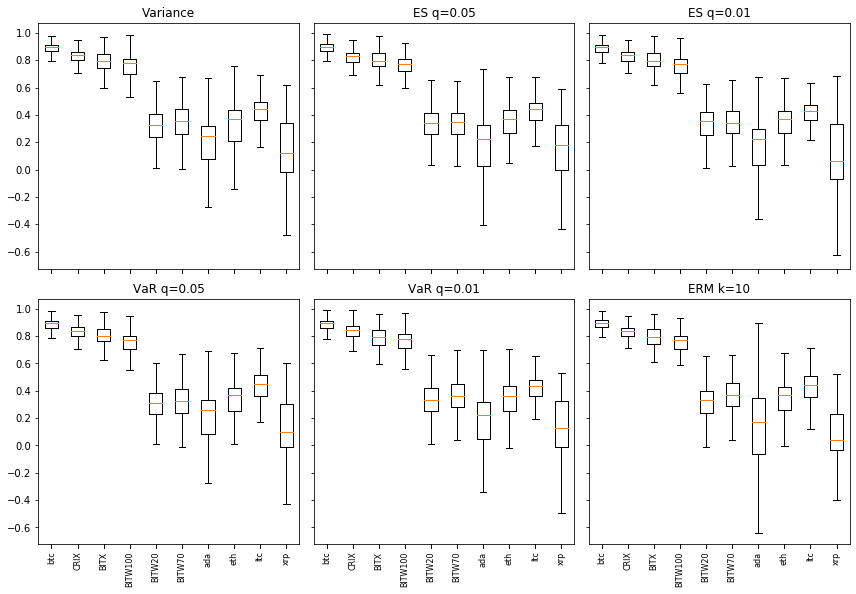

In [8]:
risk_fn = lambda x: ES(0.05, x)
plot_compare_assets_across_risk_measures_2(risk_fn, 1/200, 1000, 'ES5_HE_boxplot.pdf')